# GBSV Minichallenge 1 Notebook 3

Dieses Notbook enthält die Abgaben für die Tage 10 - 15 für die GBSV Minichallenge 1. Der Code sowie die Daten sind in einem GitHub Repository verfügbar und unter diesem Link zu finden: [GitHub Repository](https://github.com/adrianmeier2002/gbsv_minichallenges).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Day 10
### Einführung
Es sollen klassische Filtermethoden auf ein 1D-Zeitreihe-Signal angewendet werden. Hierzu werden erneut die stündlichen Wasserstandsdaten des St.-Lawrence-Stroms verwendet. Ziel ist es, kleine Schwankungen ("Rauschen") zu glätten und langfristige Trends sichtbar zu machen. Zuerst soll mithilfe eines gleitenden Mittelwerts (Moving Average) geglättet werden. So können die Stündlichen Schwankungen oder die Täglichen Schwankungen währen einer Woche geglättet werden.

In [12]:
water_raw = pd.read_csv(
    "data/st_lawrence_water.csv",
    skiprows=8, 
    usecols=[0, 1],                # nur die ersten beiden Spalten laden
    names=["Observed_date", "Sealevel"],    # Spaltennamen setzen
    parse_dates=["Observed_date"],      # Datum parsen
    encoding="latin1"
)

water_raw = water_raw.dropna()

print(water_raw.head())

        Observed_date  Sealevel
0 2015-01-01 00:00:00      0.32
1 2015-01-01 01:00:00      0.32
2 2015-01-01 02:00:00      0.33
3 2015-01-01 03:00:00      0.33
4 2015-01-01 04:00:00      0.33


Zuerst wird das signal so gefiltert, das die Täglichen Schwankungen mit einem gleitenden Mittelwert über eine Woche geglättet werden.

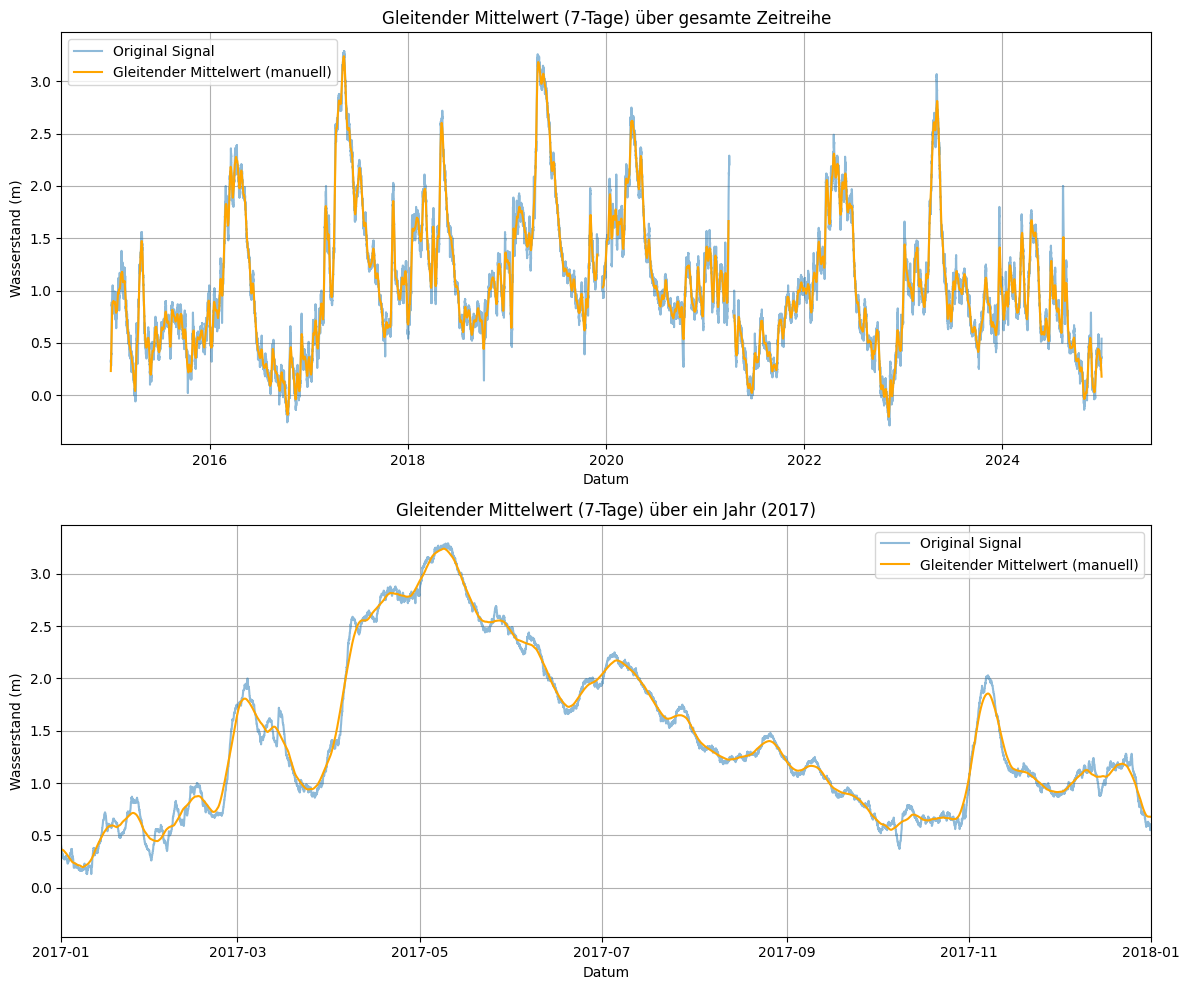

In [13]:
# Signal vorbereiten
sig = water_raw.set_index('Observed_date')['Sealevel'].asfreq('h').interpolate(limit=16)
x = sig.values

# 1) Klassischer gleitender Mittelwert (manuell)
window_size = 7 * 24  # 7-Tage-Glättung
kernel = np.ones(window_size) / window_size
x_filtered_manual = np.convolve(x, kernel, mode='same')

# 2) Visualisierung über die gesamte Zeitreihe und über ein Jahr
plt.subplots(2, 1, figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(sig.index, x, label='Original Signal', alpha=0.5)
plt.plot(sig.index, x_filtered_manual, label='Gleitender Mittelwert (manuell)', color='orange')
plt.title('Gleitender Mittelwert (7-Tage) über gesamte Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Wasserstand (m)')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(sig.index, x, label='Original Signal', alpha=0.5)
plt.plot(sig.index, x_filtered_manual, label='Gleitender Mittelwert (manuell)', color='orange')
plt.xlim([pd.Timestamp("2017-01-01"), pd.Timestamp("2018-01-01")])
plt.title('Gleitender Mittelwert (7-Tage) über ein Jahr (2017)')
plt.xlabel('Datum')
plt.ylabel('Wasserstand (m)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Im oberen Plot sieht man noch relativ wenig, wenn man aber den Zeitraum auf ein Jahr (2017) einschränkt, ist klar, dass die Kurve geglättet wird und die Täglichen Schwankungen verschwinden.

Das Signal kann auch in einem kleineren Fenster gefiltert werden, wenn uns die Täglichen Schwankungen interessieren. Hierzu wird das Signal mit einem gleitenden Mittelwert über 24 Stunden geglättet.

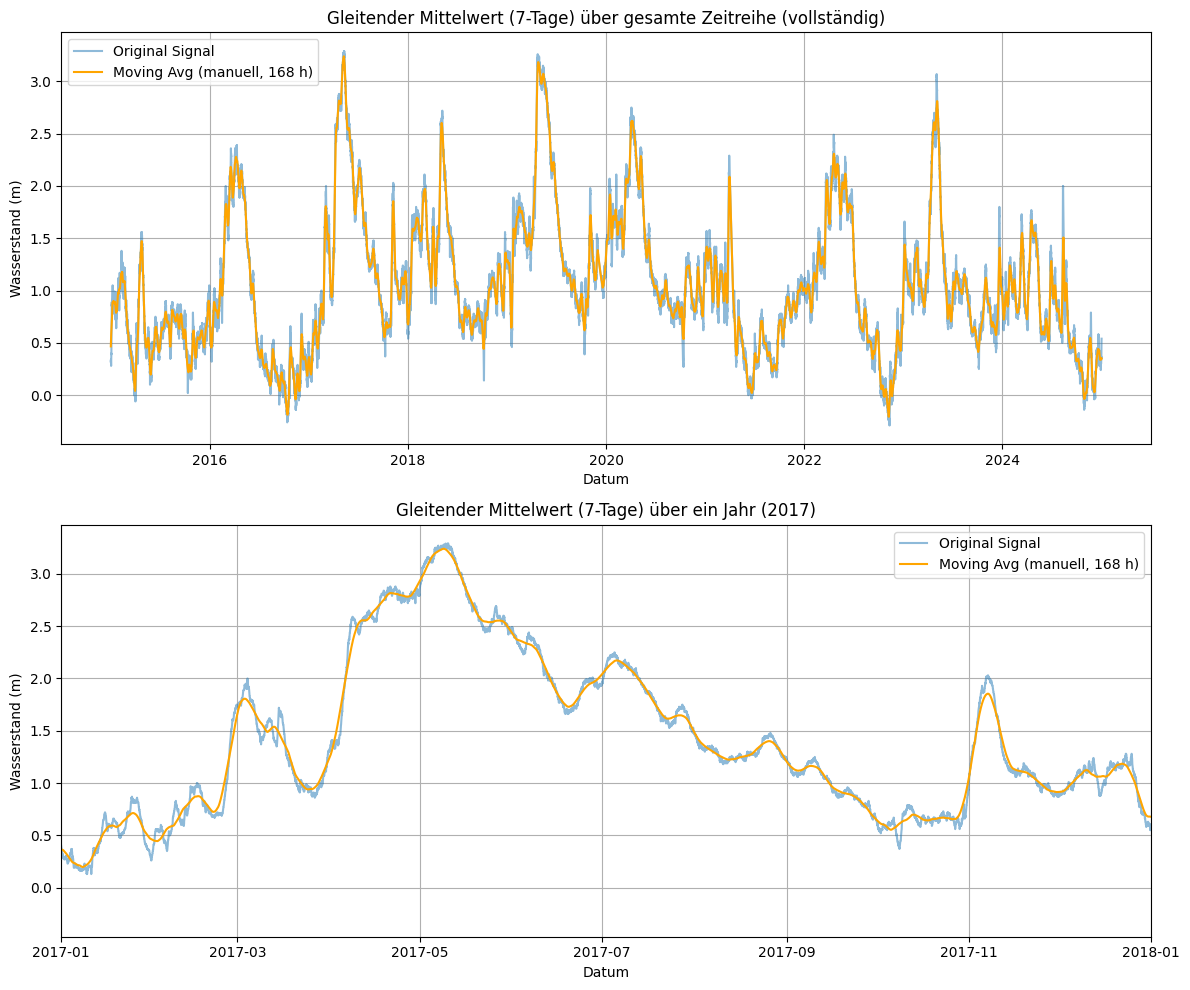

In [26]:
# --- Funktion für manuellen gleitenden Mittelwert (Prefix-Sum-Ansatz) ---
def manual_moving_average(values, window_size):
    """
    Berechnet den gleitenden Mittelwert manuell (ohne NumPy) über die gesamte Zeitreihe.
    Nutzt Prefix-Summen für effiziente Berechnung auch bei grossen Datensätzen.
    
    Parameter:
        values (list oder np.ndarray): Eingabesignal (z. B. Wasserstandswerte)
        window_size (int): Fenstergrösse in Samples (z. B. 7*24 für 7 Tage bei stündlichen Daten)
    
    Rückgabe:
        np.ndarray: geglättetes Signal, gleiche Länge wie Eingabe
    """
    x_list = [float(v) for v in values]
    N = len(x_list)
    half = window_size // 2

    # Prefix Sum vorbereiten
    prefix = [0.0] * (N + 1)
    for i in range(N):
        prefix[i + 1] = prefix[i] + x_list[i]

    # Gleitenden Mittelwert berechnen
    x_smooth = [0.0] * N
    for i in range(N):
        start = max(0, i - half)
        end = min(N, i + half + 1)
        length = end - start
        s = prefix[end] - prefix[start]
        x_smooth[i] = s / length

    return np.array(x_smooth)


# --- Signal vorbereiten ---
sig = water_raw.set_index('Observed_date')['Sealevel'].asfreq('h').interpolate(limit=16*24)
x = sig.values
dates = sig.index

# --- Parameter ---
window_size = 7 * 24  # 7 Tage = 168 Stunden

# --- Berechnung mit der Funktion ---
x_manual_centered = manual_moving_average(x, window_size)

# --- Plot: gesamte Zeitreihe + Jahr 2017 ---
plt.figure(figsize=(12,10))

# 1) Gesamtansicht
plt.subplot(2,1,1)
plt.plot(dates, x, label='Original Signal', alpha=0.5)
plt.plot(dates, x_manual_centered, label=f'Moving Avg (manuell, {window_size} h)', color='orange')
plt.title('Gleitender Mittelwert (7-Tage) über gesamte Zeitreihe (vollständig)')
plt.xlabel('Datum')
plt.ylabel('Wasserstand (m)')
plt.legend()
plt.grid()

# 2) Zoom auf Jahr 2017
plt.subplot(2,1,2)
plt.plot(dates, x, label='Original Signal', alpha=0.5)
plt.plot(dates, x_manual_centered, label=f'Moving Avg (manuell, {window_size} h)', color='orange')
plt.xlim([pd.Timestamp("2017-01-01"), pd.Timestamp("2018-01-01")])
plt.title('Gleitender Mittelwert (7-Tage) über ein Jahr (2017)')
plt.xlabel('Datum')
plt.ylabel('Wasserstand (m)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Man sieht auch hier, dass die Kurve geglättet wird, aber die Täglichen Schwankungen bleiben erhalten. Jedoch sind die grösseren Spitzten durch sanftere Übergänge ersetzt worden.

### Vergleich mit Numpy
In Numpy kann der gleitende Mittelwert auch mit der Funktion `np.convolve` berechnet werden. Nachfolgend soll gezeigt werden, ob es eine Differenz zwischen der manuellen Berechnung und der Numpy-Funktion gibt.

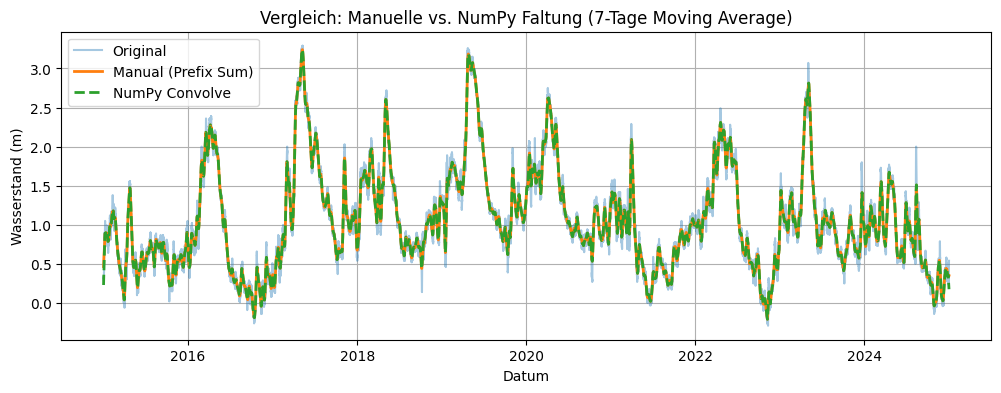

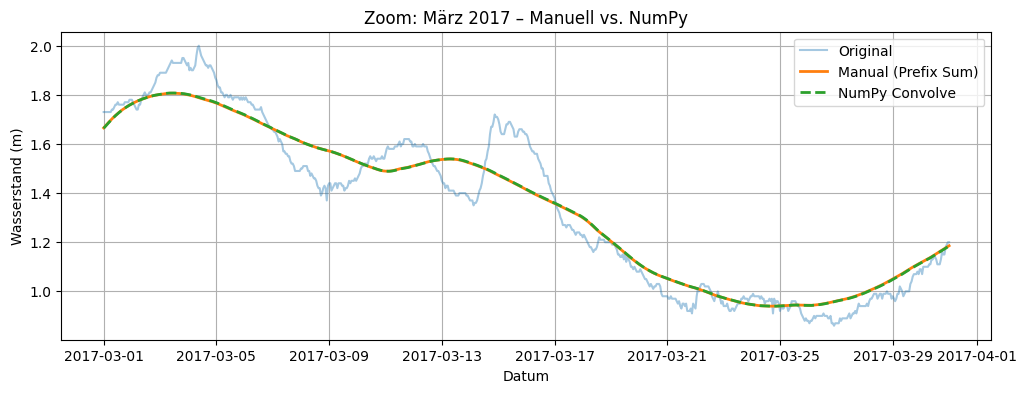

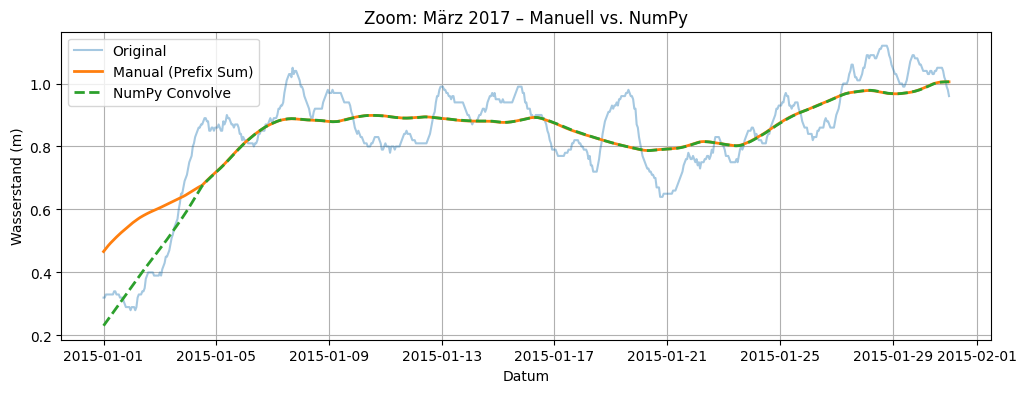

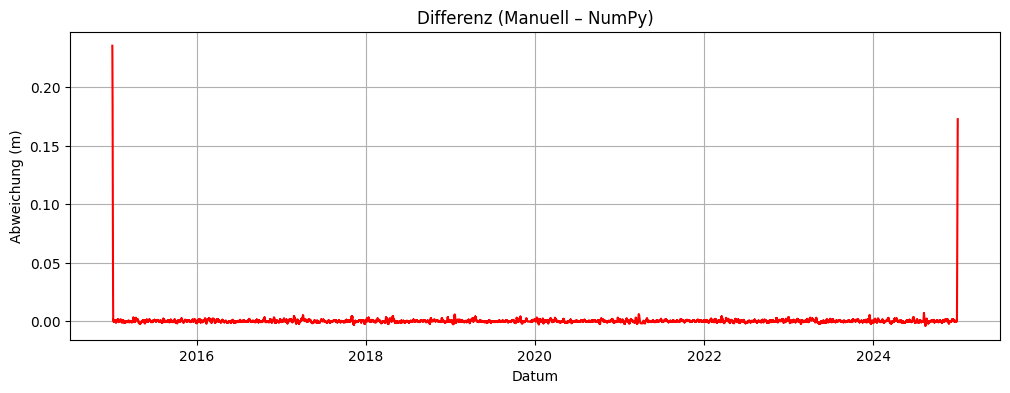

RMSE zwischen manuell & NumPy: 0.005864 m
Maximale Abweichung: 0.235579 m
Mittlere Abweichung: 0.000939 m


In [ ]:
# --- Signal vorbereiten ---
sig = water_raw.set_index('Observed_date')['Sealevel'].asfreq('h').interpolate(limit=16*24)
x = sig.values.astype(float)
dates = sig.index

# --- Parameter ---
window_size = 7 * 24  # 7-Tage-Glättung

# --- 1) Manuelle Berechnung (Funktionsaufruf) ---
x_manual = manual_moving_average(x, window_size)

# --- 2) NumPy Faltung (Referenz) ---
kernel = np.ones(window_size) / window_size
x_numpy = np.convolve(x, kernel, mode='same')

# --- 3) Differenz berechnen ---
diff = x_manual - x_numpy

# --- 4) Plot: gesamtes Signal ---
plt.figure(figsize=(12,4))
plt.plot(dates, x, label='Original', alpha=0.4)
plt.plot(dates, x_manual, label='Manual (Prefix Sum)', linewidth=2)
plt.plot(dates, x_numpy, '--', label='NumPy Convolve', linewidth=2)
plt.title('Vergleich: Manuelle vs. NumPy Faltung (7-Tage Moving Average)')
plt.xlabel('Datum')
plt.ylabel('Wasserstand (m)')
plt.legend()
plt.grid()
plt.show()

# --- 5) Zoom & Vergleich ---
zoom_mask = (dates >= '2017-03-01') & (dates <= '2017-03-31')
plt.figure(figsize=(12,4))
plt.plot(dates[zoom_mask], x[zoom_mask], label='Original', alpha=0.4)
plt.plot(dates[zoom_mask], x_manual[zoom_mask], label='Manual (Prefix Sum)', linewidth=2)
plt.plot(dates[zoom_mask], x_numpy[zoom_mask], '--', label='NumPy Convolve', linewidth=2)
plt.title('Zoom: März 2017 – Manuell vs. NumPy')
plt.xlabel('Datum')
plt.ylabel('Wasserstand (m)')
plt.legend()
plt.grid()
plt.show()

# --- 6) Vergleich an den Rändern ---
zoom_mask = (dates >= '2015-01-01') & (dates <= '2015-01-31')
plt.figure(figsize=(12,4))
plt.plot(dates[zoom_mask], x[zoom_mask], label='Original', alpha=0.4)
plt.plot(dates[zoom_mask], x_manual[zoom_mask], label='Manual (Prefix Sum)', linewidth=2)
plt.plot(dates[zoom_mask], x_numpy[zoom_mask], '--', label='NumPy Convolve', linewidth=2)
plt.title('Zoom: März 2017 – Manuell vs. NumPy')
plt.xlabel('Datum')
plt.ylabel('Wasserstand (m)')
plt.legend()
plt.grid()
plt.show()

# --- 7) Differenzplot ---
plt.figure(figsize=(12,4))
plt.plot(dates, diff, color='red')
plt.title('Differenz (Manuell – NumPy)')
plt.xlabel('Datum')
plt.ylabel('Abweichung (m)')
plt.grid()
plt.show()

# --- 8) Quantitative Auswertung ---
rmse = np.sqrt(np.mean(diff**2))
max_dev = np.max(np.abs(diff))
mean_dev = np.mean(np.abs(diff))

print(f"RMSE zwischen manuell & NumPy: {rmse:.6f} m")
print(f"Maximale Abweichung: {max_dev:.6f} m")
print(f"Mittlere Abweichung: {mean_dev:.6f} m")

Im Plot sieht man, dass die beiden Kurven übereinander liegen. Einzig am Anfang und Ende gibt es kleine Abweichungen, da die Ränder unterschiedlich behandelt werden. Dies ist auch im Plot ersichtlich wenn man die Ränder Betrachtet, dass die beiden Kurven etwas anders beginnen, dann aber nach einigen Tagen übereinander liegen.

## Day 11
### Use Case
Um zu sehen, ob der Klimawandel einen Einfluss auf den Wasserstand des St.-Lawrence-Stroms hat, soll ein Trend über die Jahre berechnet werden. Hierzu wird das Signal mit einem gleitenden Mittelwert über 12 Monate geglättet. So werden die Saisonalitäten wie die Schneeschmelze entfernt und ein langfristiger Trend wird sichtbar. Falls es einen Trend gibt, könnte dies auf den Klimawandel hindeuten un man müsste weitere Untersuchungen anstellen um die Infrastruktur der Zukunft den neuen Gegebenheiten anzupassen.

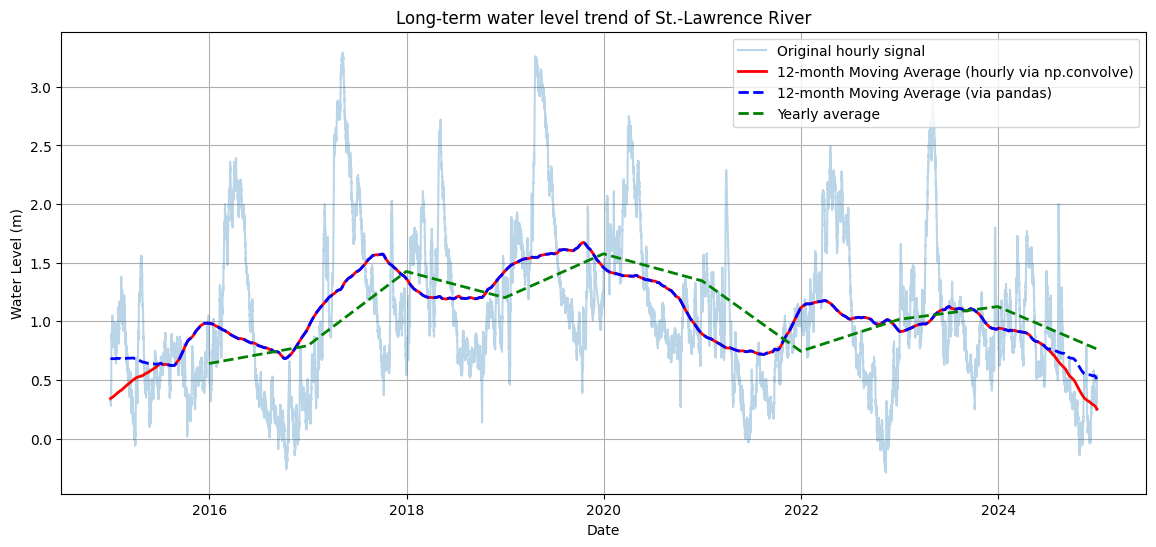

In [16]:
# Signal vorbereiten (jährliche Mittelwerte aus täglichen Messungen)
sig = water_raw.set_index('Observed_date')['Sealevel'].asfreq('h').interpolate(limit=16*24)
dates = sig.index
x = sig.values

# 2. 12-Monats-Gleitender Mittelwert in Stunden umrechnen
# 12 Monate ≈ 365 Tage -> 365*24 Stunden
window_hours = 365 * 24
kernel = np.ones(window_hours) / window_hours

# 3. Convolution
x_trend = np.convolve(x, kernel, mode='same')

# 4. Pandas Rolling Mean (als Vergleich)
x_trend_pd = sig.rolling(window='365D', center=True).mean()

# 4. Vergleich: Jährlicher Mittelwert
yearly_avg = sig.resample('YE').mean()

# 5. Visualisierung
plt.figure(figsize=(14,6))
plt.plot(dates, x, alpha=0.3, label='Original hourly signal')
plt.plot(dates, x_trend, color='red', label='12-month Moving Average (hourly via np.convolve)', linewidth=2)
plt.plot(x_trend_pd.index, x_trend_pd.values, '--', color='blue', label='12-month Moving Average (via pandas)', linewidth=2)  
plt.plot(yearly_avg.index, yearly_avg.values, '--', color='green', label='Yearly average', linewidth=2)
plt.title('Long-term water level trend of St.-Lawrence River')
plt.xlabel('Date'); plt.ylabel('Water Level (m)')
plt.grid()
plt.legend()
plt.show()

Man sieht im Plot keine klare Tendenz. Was aber im Bezug auf das Filtering auffällt, ist dass die saisonalen Schwankungen deutlich reduziert wurden. Im Vergleich sieht man noch das Jährliche Mittel abgebildet durch die grüne Linie. Diese Linie ist aber nicht so aussagekräftig wie die geglättete Kurve obwohl man sehen kann, dass diese ähnlich verläuft.

## Day 12
Um die Daten aus der Konvolution wieder zurückzutransformieren, wird eine Dekonvolution durchgeführt. Ziel ist es mit einer Wiener-Dekonvolution das ursprüngliche Signal wiederherzustellen. Hierzu wird die geglättete Kurve (12-Monats-Moving Average) verwendet und mit dem gleichen Kernel wie bei der Faltung gefiltert. Dadurch soll das ursprüngliche Signal wiederhergestellt werden.

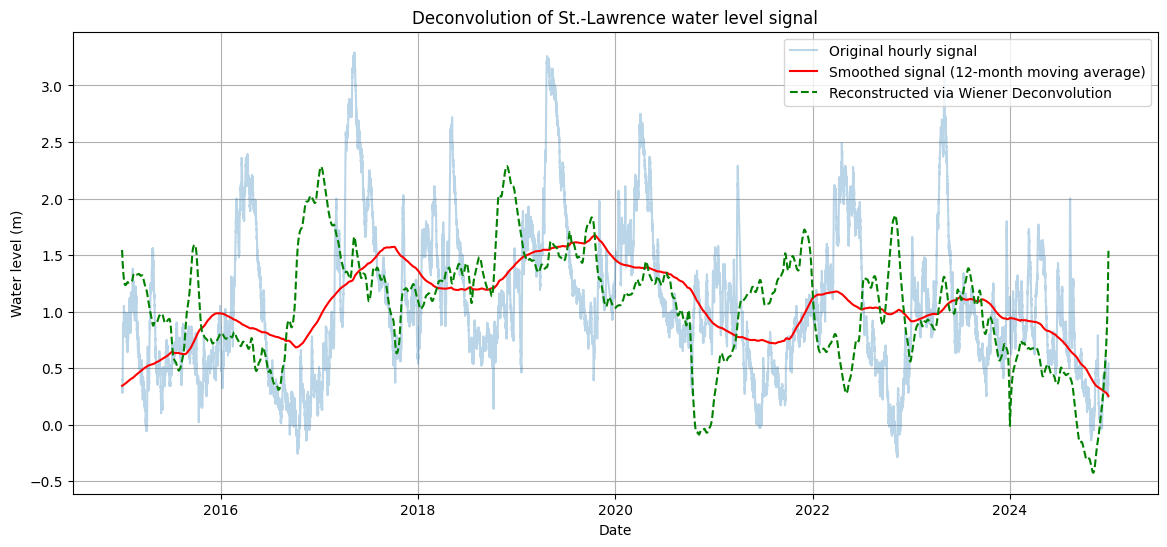

RMSE between original and reconstructed signal: 0.7697870058437556


In [17]:
# 1. Original signal (hourly)
sig = water_raw.set_index('Observed_date')['Sealevel'].asfreq('h').interpolate(limit=16*24)
x = sig.values
dates = sig.index

# 2. Define kernel: 12-month moving average (same as before)
window_hours = 365 * 24
kernel = np.ones(window_hours) / window_hours

# 3. Convolution (already done for trend)
x_trend = np.convolve(x, kernel, mode='same')

# 4. Deconvolution using simple Wiener approach
# Small regularization parameter to avoid amplifying noise
eps = 1e-3
kernel_fft = np.fft.fft(kernel, n=len(x))
x_trend_fft = np.fft.fft(x_trend)

x_reconstructed = np.fft.ifft(x_trend_fft * np.conj(kernel_fft) / (kernel_fft * np.conj(kernel_fft) + eps)).real

# 5. Visualization
plt.figure(figsize=(14,6))
plt.plot(dates, x, alpha=0.3, label='Original hourly signal')
plt.plot(dates, x_trend, color='red', label='Smoothed signal (12-month moving average)')
plt.plot(dates, x_reconstructed, color='green', linestyle='--', label='Reconstructed via Wiener Deconvolution')
plt.title('Deconvolution of St.-Lawrence water level signal')
plt.xlabel('Date')
plt.ylabel('Water level (m)')
plt.grid()
plt.legend()
plt.show()

# 6. Quantitative comparison
diff = x - x_reconstructed
print("RMSE between original and reconstructed signal:", np.sqrt(np.mean(diff**2)))

Man sieht, dass das neu erechnete Signal (grün) dem Originalsignal (blau) nur an einigen Stellen ähnelt. Insgesamt ist die Rekonstruktion nicht sehr gut gelungen. Dies liegt daran, dass die Dekonvolution sehr empfindlich auf Rauschen im Signal reagiert. Da das Originalsignal viele kleine Schwankungen (Rauschen) enthält, wird dieses Rauschen bei der Dekonvolution verstärkt, was zu einer schlechten Rekonstruktion führt. Durch die anpassung des Regularisierungsparameters (eps) kann die Rekonstruktion etwas verbessert werden, aber es ist immer noch nicht perfekt.

In einem nächsten Schritt wird noch versuch das Signal mithilfe einer Tikhonov-Regularisierung zu rekonstruieren. Der Unterschied zur Wiener-Dekonvolution ist, dass hier ein Regularisierungsterm hinzugefügt wird, der die Lösung glättet und somit das Rauschen reduziert.

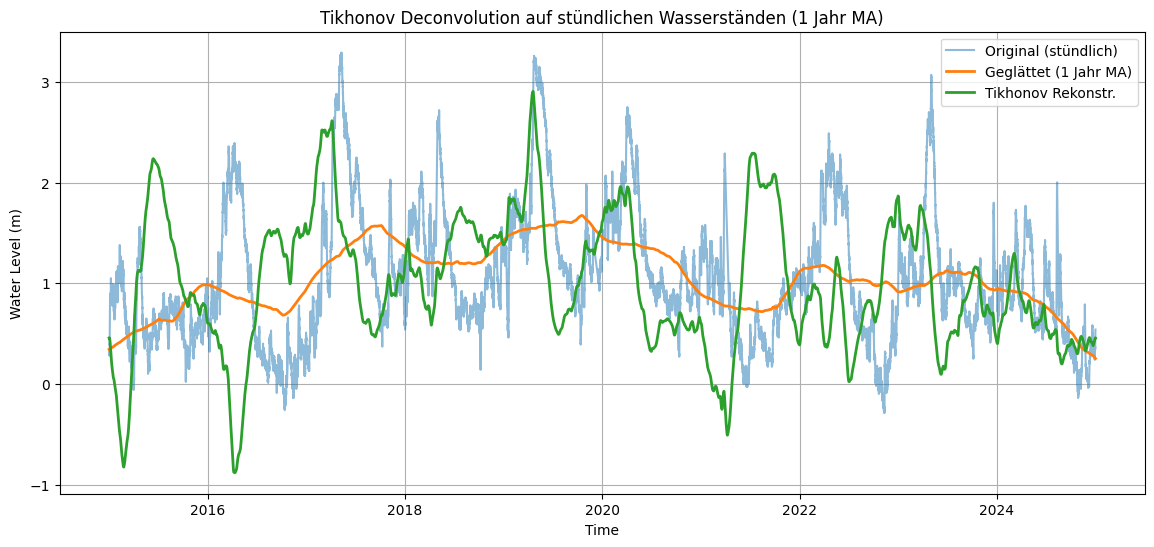

RMSE Original vs. Rekonstr.: 0.905 Meter


In [18]:
# --- Daten vorbereiten ---
sig = water_raw.set_index('Observed_date')['Sealevel'].asfreq('h').interpolate(limit=24*16)
x_orig = sig.values.astype(float)
t_index = sig.index

# --- Glättungskernel (z.B. 1 Jahr Mittelwert) ---
kernel_size = 365 * 24  # 1 Jahr in Stunden
kernel = np.ones(kernel_size) / kernel_size

# --- Tikhonov deconvolution ---
X = np.fft.fft(x_orig)
K = np.fft.fft(kernel, n=len(X))

lam = 0.06  # Regularisierungsparameter
X_deconv = np.conj(K) / (np.abs(K)**2 + lam) * X
x_recon = np.fft.ifft(X_deconv).real

# --- Vergleich Visualisierung ---
plt.figure(figsize=(14,6))
plt.plot(t_index, x_orig, alpha=0.5, label='Original (stündlich)')
plt.plot(t_index, np.convolve(x_orig, kernel, mode='same'), label='Geglättet (1 Jahr MA)', linewidth=2)
plt.plot(t_index, x_recon, label='Tikhonov Rekonstr.', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.title('Tikhonov Deconvolution auf stündlichen Wasserständen (1 Jahr MA)')
plt.legend()
plt.grid()
plt.show()

# --- Quantitative Maßzahlen ---
rmse = np.sqrt(np.mean((x_orig - x_recon)**2))
print(f"RMSE Original vs. Rekonstr.: {rmse:.3f} Meter")

Bei der Tikhonov-Regularisierung sieht die Rekonstruktion schon deutlich besser aus. Das rekonstruierte Signal (grün) folgt dem Originalsignal (blau) viel besser als bei der Wiener-Dekonvolution. Der RMSE-Wert ist allerdings immer noch relativ hoch, was darauf hindeutet, dass es immer noch Unterschiede zwischen dem Original- und dem rekonstruierten Signal gibt.

## Day 13
### Vergleich der Methoden
Man sieht auf den Plots, dass die Dekonvolutionen einige Teile der Originalsignale annähernd rekonstruieren konnten, aber es gibt immer noch deutliche Unterschiede. Die Tikhonov-Regularisierung scheint etwas besser zu funktionieren als die Wiener-Dekonvolution, da das rekonstruierte Signal dem Originalsignal etwas ähnlicher sieht. Der RMSE-Wert ist bei der Tikhonov-Regularisierung etwas höher als bei der Wiener-Dekonvolution. Jedoch liegen beide Werte etwa bei 0.8 Meter, was darauf hindeutet, dass es immer noch erhebliche Unterschiede zwischen dem Original- und dem rekonstruierten Signal gibt.

Für meinen Anwendungsfall, bei dem ich langfristige Trends im Wasserstand des St.-Lawrence-Stroms analysieren möchte, ist die Dekonvolution nicht unbedingt notwendig. Da die Daten bereits stündlich vorliegen und deshalb eine Rekonstruktion auf den aktuellen Daten nur wenig sinnvoll ist. Ein Fall für eine Dekonvolution wäre, wenn ich nur monatliche Durchschnittswerte hätte und daraus die stündlichen Werte rekonstruieren müsste. In diesem Fall könnte die Tikhonov-Regularisierung eine gute Wahl sein, da sie das Rauschen reduziert und eine glattere Rekonstruktion liefert.

## Day 14
Durch die Konvolution hat man gesehen, dass im angeschauten Zeitraum keine langfristigen Trends im Wasserstand des St.-Lawrence-Stroms zu erkennen sind. Es wäre vielleicht aber sinnvoll, die Daten über einen längeren Zeitraum zu analysieren, um mögliche Trends zu erkennen. Trotzdem kann man durch eine Glättung die saisonalen Schwankungen reduzieren und so den langfristigen Trend besser erkennen.

Die Rekonstuktion des Signals durch die Dekonvolution war nicht sehr erfolgreich. Dies liegt daran, dass die Dekonvolution sehr empfindlich auf Rauschen im Signal reagiert. Da das Originalsignal viele kleine Schwankungen (Rauschen) enthält, wird dieses Rauschen bei der Dekonvolution verstärkt, was zu einer schlechten Rekonstruktion führt. Auch anwendungsmässig, macht eine Dekonvolution in diesem Fall wenig Sinn, da die Daten bereits stündlich vorliegen und eine Rekonstruktion auf den aktuellen Daten nur wenig sinnvoll ist.

## Day 15
### Reflektion
Ich habe während dieser Minichallenge einiges über 1D-Signale gelernt. Angefangen damit, dass für mich Signale immer nur Audiosignale waren und ich schnell gesehen habe, dass es viele andere Anwendungsfälle gibt. Gerade die Visualisierungen der Signale und der einzelnen Analysen fand ich gelungen. Sie haben mir oft geholfen, das Ergebniss und auch die angewendeten Methoden besser zu verstehen.

Ausbaufähig wäre wahrscheinlich noch der Mathematische Hintergrund zu den einzelnen Methoden. Hier habe ich zwar die Grundidee verstanden, aber ich denke, dass ich hier noch mehr lernen könnte. Auch bei der Dekonvolution hatte ich wahrscheinlich nicht die besten Daten und konnte daher nicht das beste Ergebniss erzielen. 

Am Lernreichsten fand ich das Niquist-Shannon Sampling Theorem. Gerade hier konnte ich durch die Visualisierungen sehr gut verstehen, warum dieses Theorem so wichtig ist und auch, dass es nicht immer eine perfekte Rekonstruktion gibt. Beipielsweise habe ich erkannt, das eine Saisonalität in der Theorie nur alle 6 Monate gemessen werden muss aber in der Praxis macht es Sinn, dies häufiger zu tun um eine bessere Rekonstruktion zu erhalten.